# Model building and expansion for golf putting

[Tutorial](https://docs.pymc.io/pymc-examples/examples/case_studies/putting_workflow.html)

## Setup

### Imports

In [1]:
import io
from typing import Optional

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import scipy
import scipy.stats as st
import seaborn as sns

### Settings

In [2]:
%config InlineBackend.figure_format = "retina"

az.style.use("arviz-darkgrid")
gg.theme_set(gg.theme_minimal)
sns.set_style("whitegrid")

RANDOM_SEED = 432
np.random.seed(RANDOM_SEED)

HDI_PROB = 0.89

### Data

In [3]:
# golf putting data from berry (1996)
golf_data_str = """
distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24
"""


golf_data = pd.read_csv(io.StringIO(golf_data_str), sep=" ")
golf_data.head()

,distance,tries,successes
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149


In [4]:
def plot_golf_data(
    df: pd.DataFrame, ax=None, plt_title: Optional[str] = None
) -> plt.Axes:
    df["frac_success"] = df.successes / df.tries
    success_intervals = st.beta(df.successes, df.tries - df.successes)
    df["success_interval_low"] = success_intervals.interval(0.68)[0]
    df["success_interval_high"] = success_intervals.interval(0.68)[1]

    ax = sns.scatterplot(data=df, x="distance", y="frac_success", color="black", ax=ax)
    ax.vlines(df.distance, *success_intervals.interval(0.68), color="black", label=None)
    ax.set_xlabel("distance from hole")
    ax.set_ylabel("fraction of putts made")
    if plt_title is not None:
        ax.set_title(plt_title)
    ax.set_ylim(bottom=0, top=1)
    sns.despine(ax=ax)
    return ax

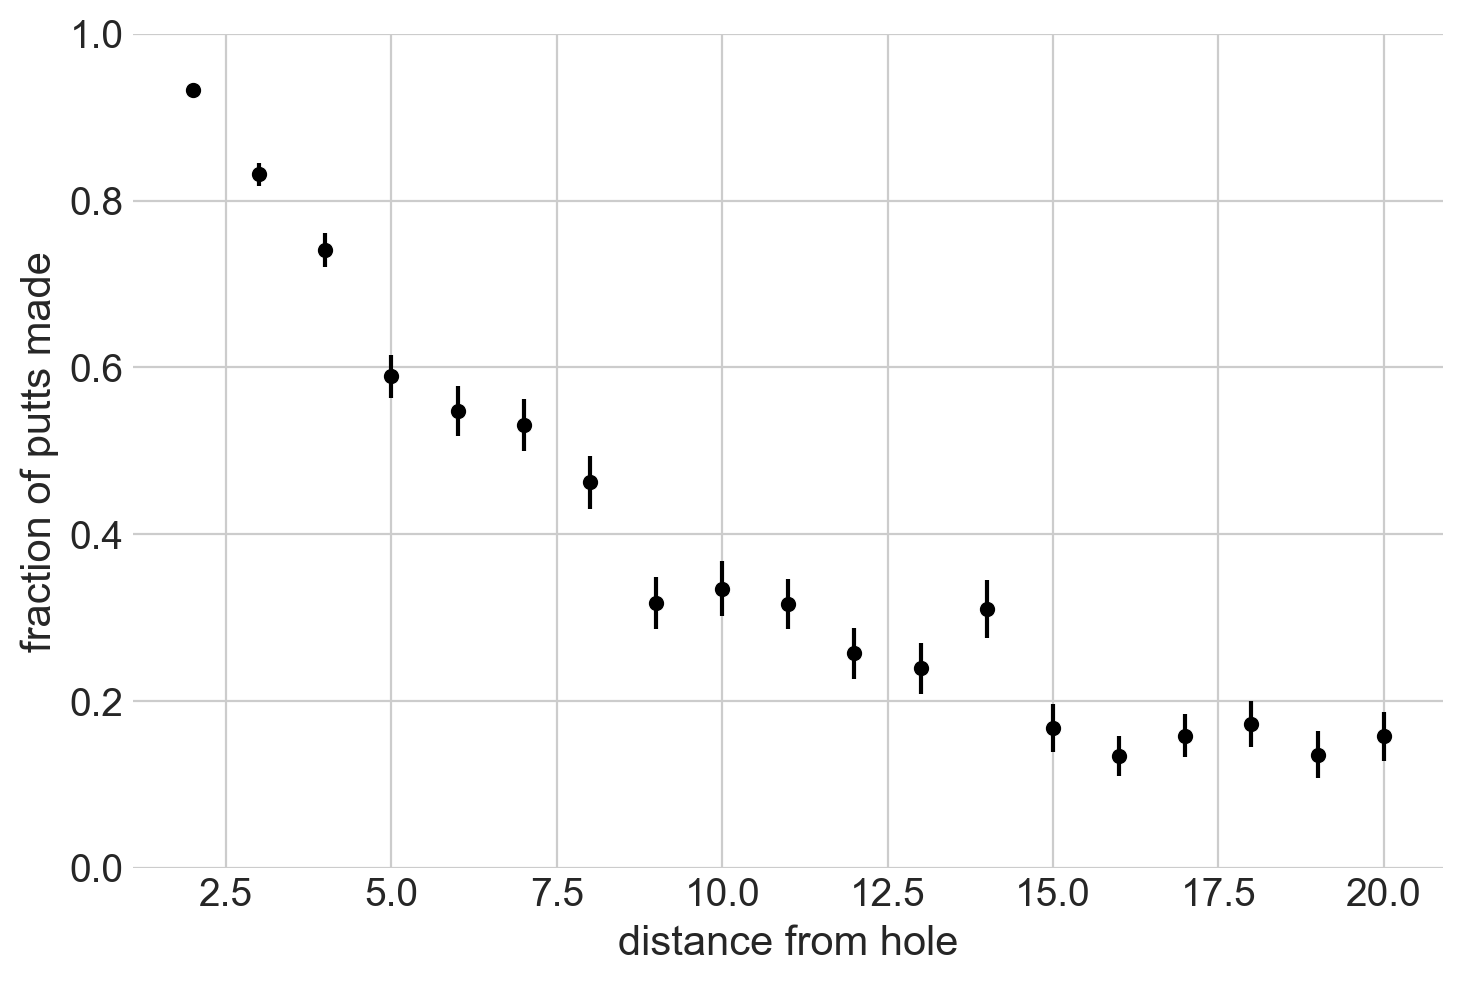

In [5]:
plot_golf_data(golf_data);

## Modeling

### Logit model

A traditional logit-binomial model on the number of success given the number of trials.

$$
\text{num. success} \sim \text{Binomial}(\text{tries}, p(\text{successes})) \\
p(\text{success}) = \text{logit}^{-1} (a \times \text{distance} + b) \\
a \sim \mathcal{N}(0, 1) \quad b \sim \mathcal{N}(0, 1)
$$

In [6]:
def logit_model(data: pd.DataFrame) -> pm.Model:
    with pm.Model() as logit_binom:
        a = pm.Normal("a", 0, 1)
        b = pm.Normal("b", 0, 1)

        success = pm.Binomial(
            "success",
            n=data.tries,
            p=pm.math.invlogit(a * data.distance + b),
            observed=data.successes,
        )
    return logit_binom

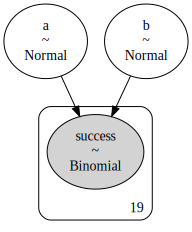

In [7]:
m1_logit_model = logit_model(golf_data)
pm.model_to_graphviz(m1_logit_model)

In [8]:
with m1_logit_model:
    m1_logit_trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=2,
        random_seed=RANDOM_SEED,
        target_accept=0.95,
        return_inferencedata=True,
    )

pm.summary(m1_logit_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.255,0.007,-0.268,-0.243,0.000,0.000,1211.0,1223.0,1.0
b,2.226,0.058,2.116,2.335,0.002,0.001,1226.0,1225.0,1.0


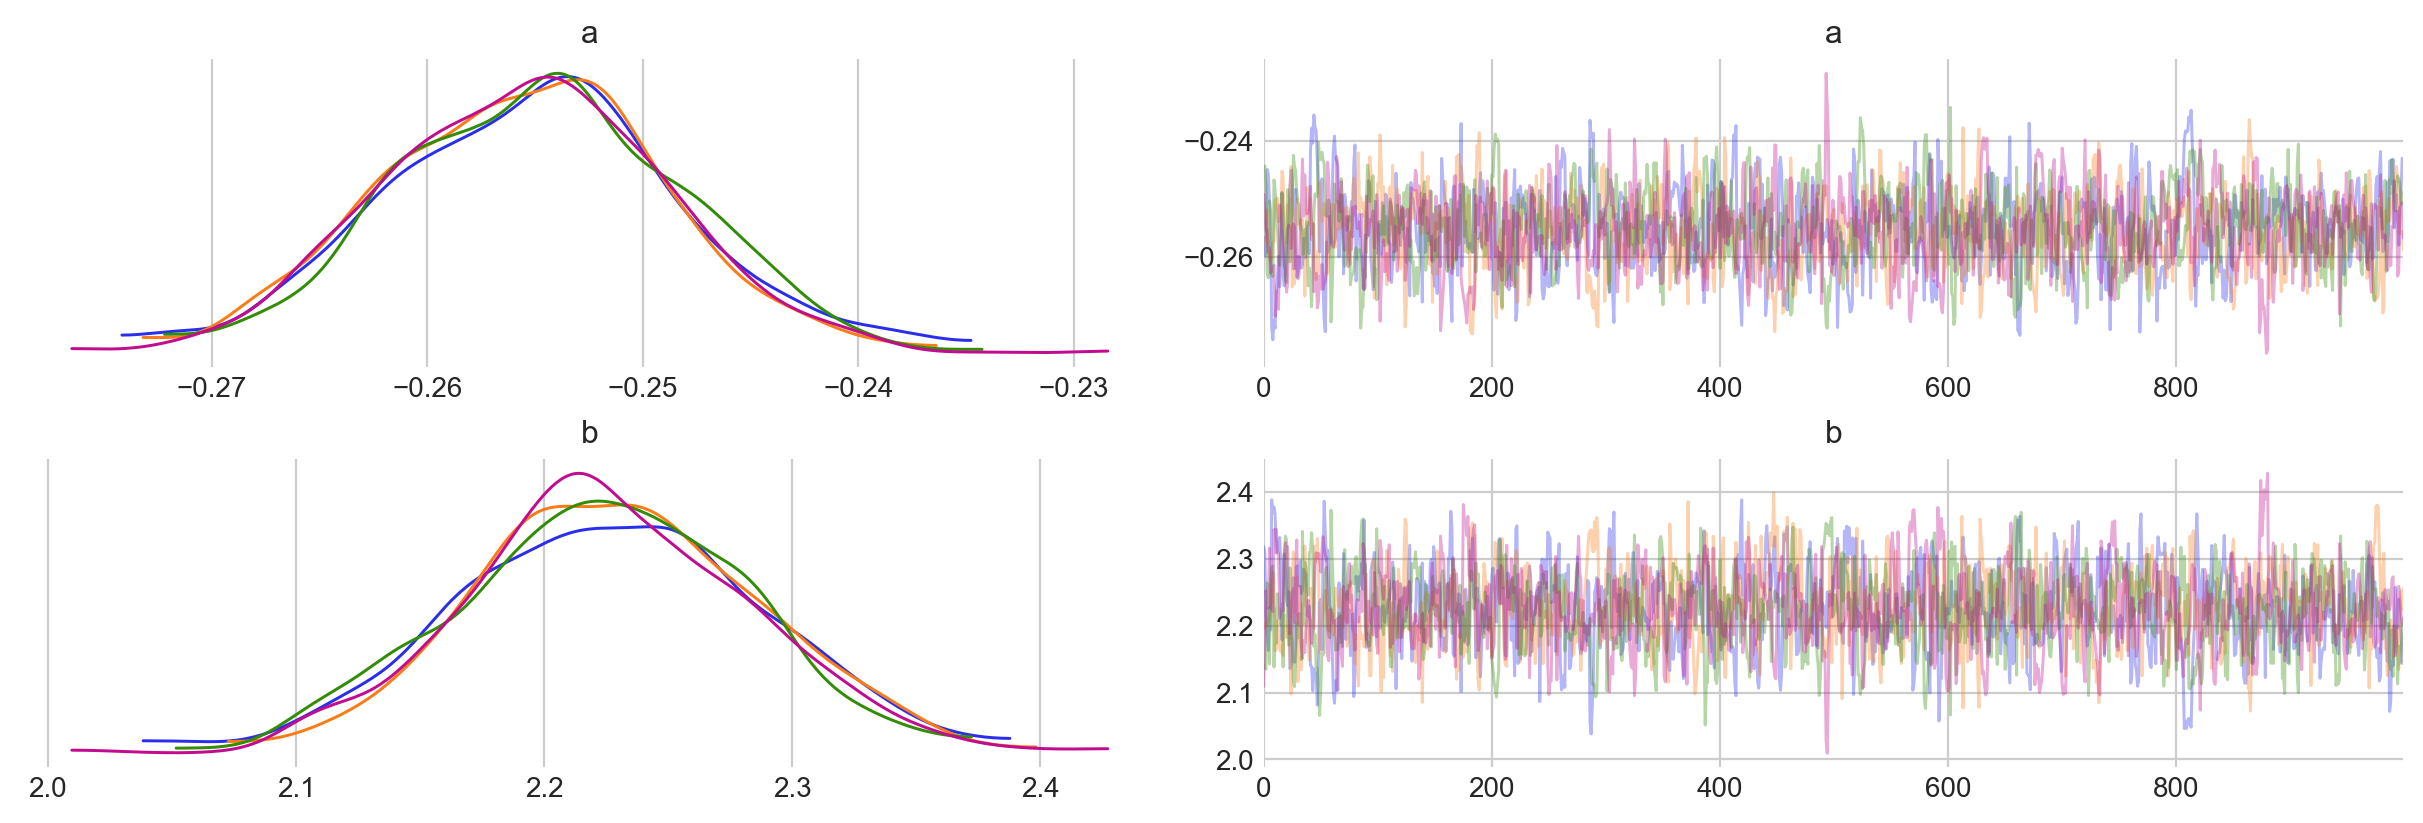

In [9]:
az.plot_trace(m1_logit_trace, compact=False);

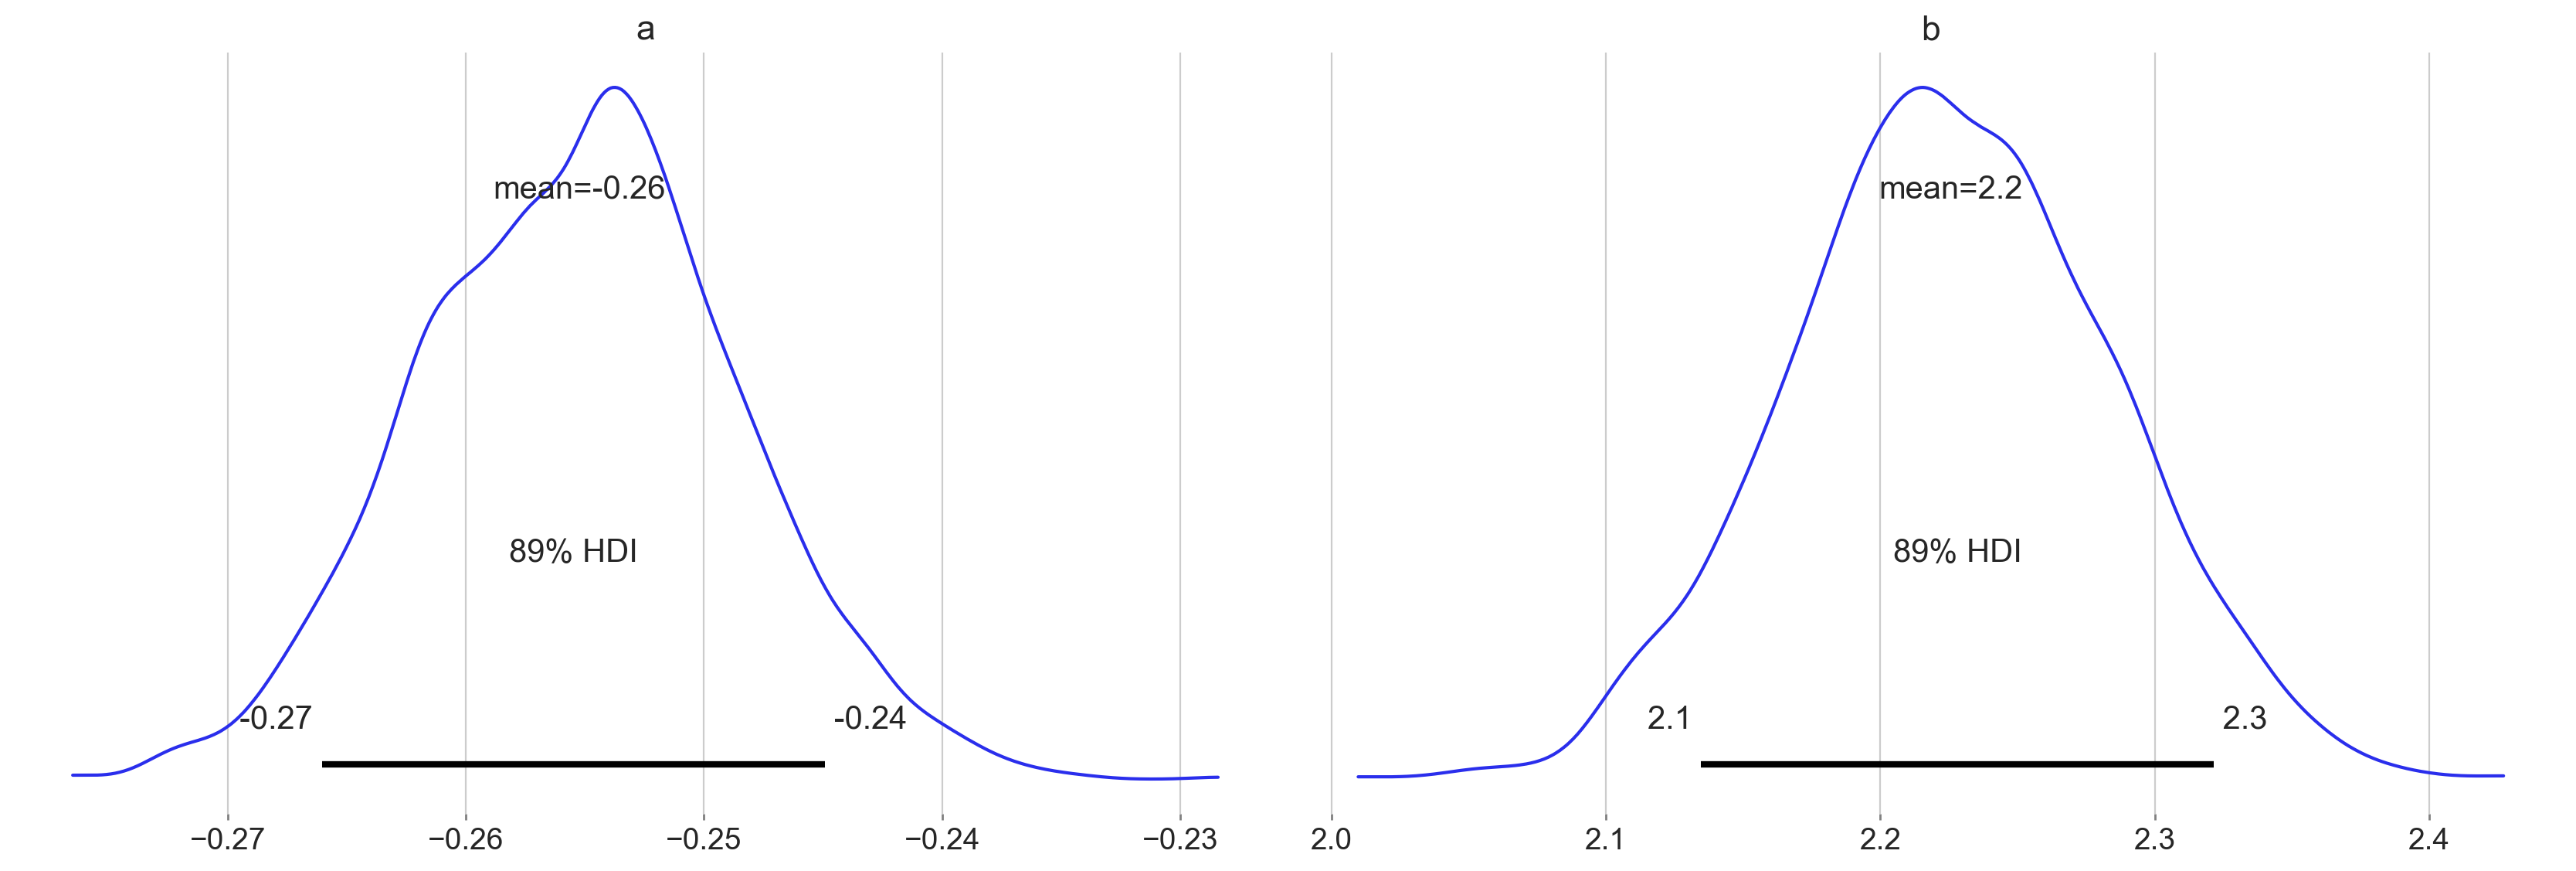

In [10]:
az.plot_posterior(m1_logit_trace, hdi_prob=HDI_PROB);

In [11]:
with m1_logit_model:
    m1_logit_ppc = pm.sample_posterior_predictive(m1_logit_trace, progressbar=False)

In [12]:
logit_ppc_success = m1_logit_ppc["success"].T / golf_data.tries.values.reshape(-1, 1)

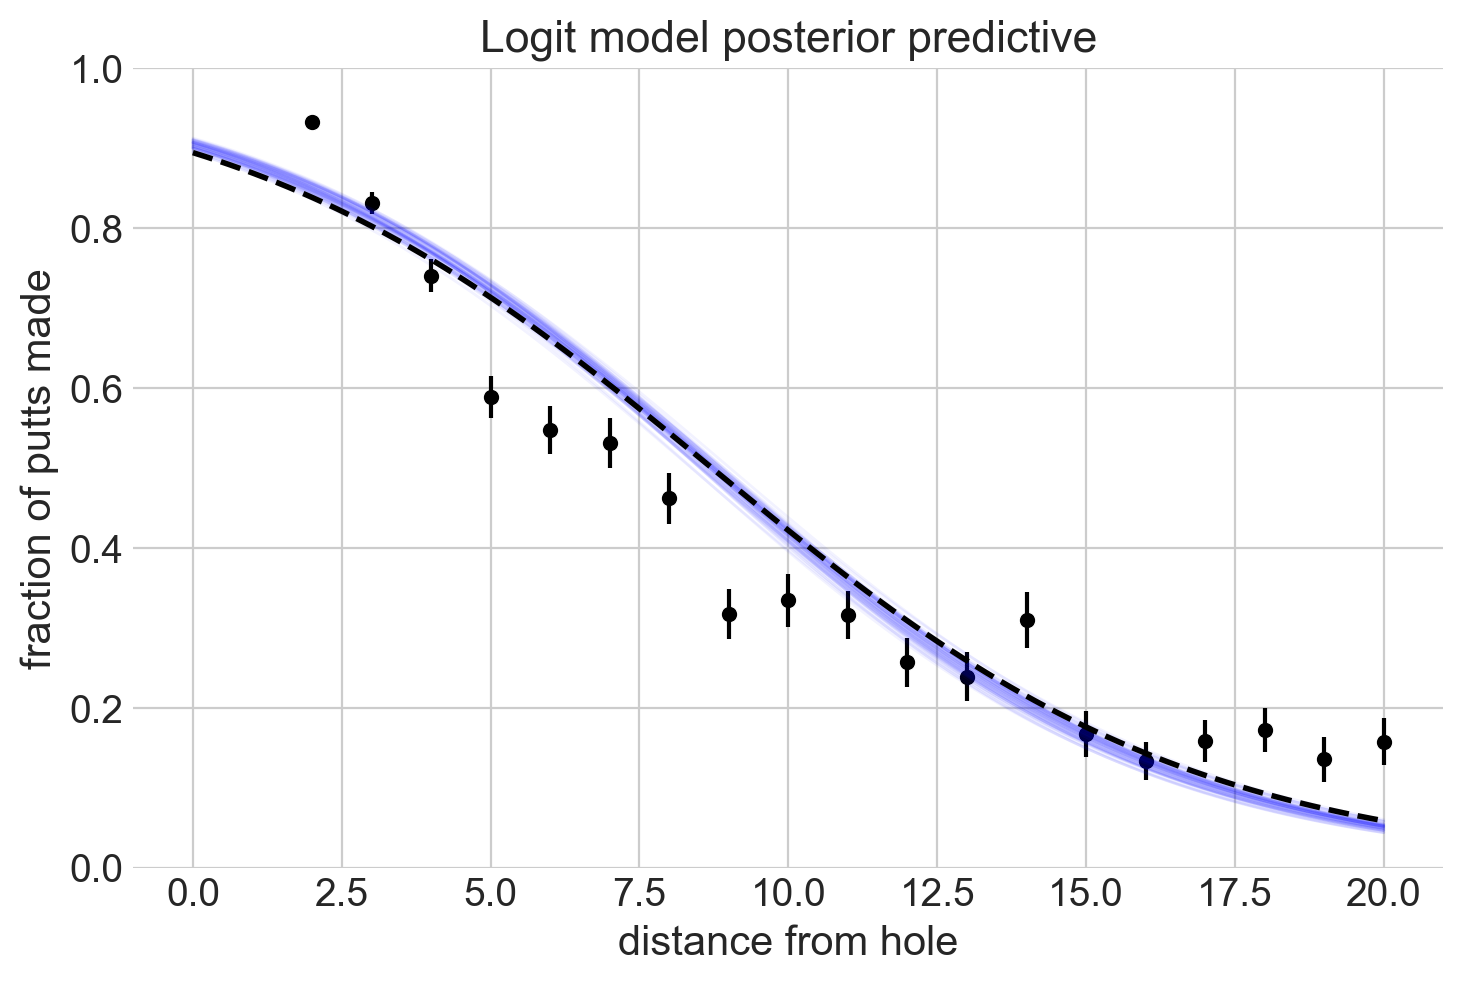

In [13]:
a_post = m1_logit_trace.posterior["a"].values.flatten()
b_post = m1_logit_trace.posterior["b"].values.flatten()
d = np.linspace(0, golf_data.distance.max(), 100)

ax = plot_golf_data(golf_data, plt_title="Logit model posterior predictive")

for i in np.random.randint(0, len(a_post), 50):
    y = scipy.special.expit(a_post[i] * d + b_post[i])
    ax.plot(d, y, alpha=0.05, lw=1, color="blue")

y_mean = scipy.special.expit(a_post * d.reshape(-1, 1) + b_post).mean(axis=1)
ax.plot(d, y, color="black", lw=2, linestyle="--")

plt.show()

In [14]:
prob_at_50 = scipy.special.expit(a_post * 50 + b_post).mean() * 100
print(f"probability of success at 50 feet: {prob_at_50:.5f}%")

probability of success at 50 feet: 0.00276%


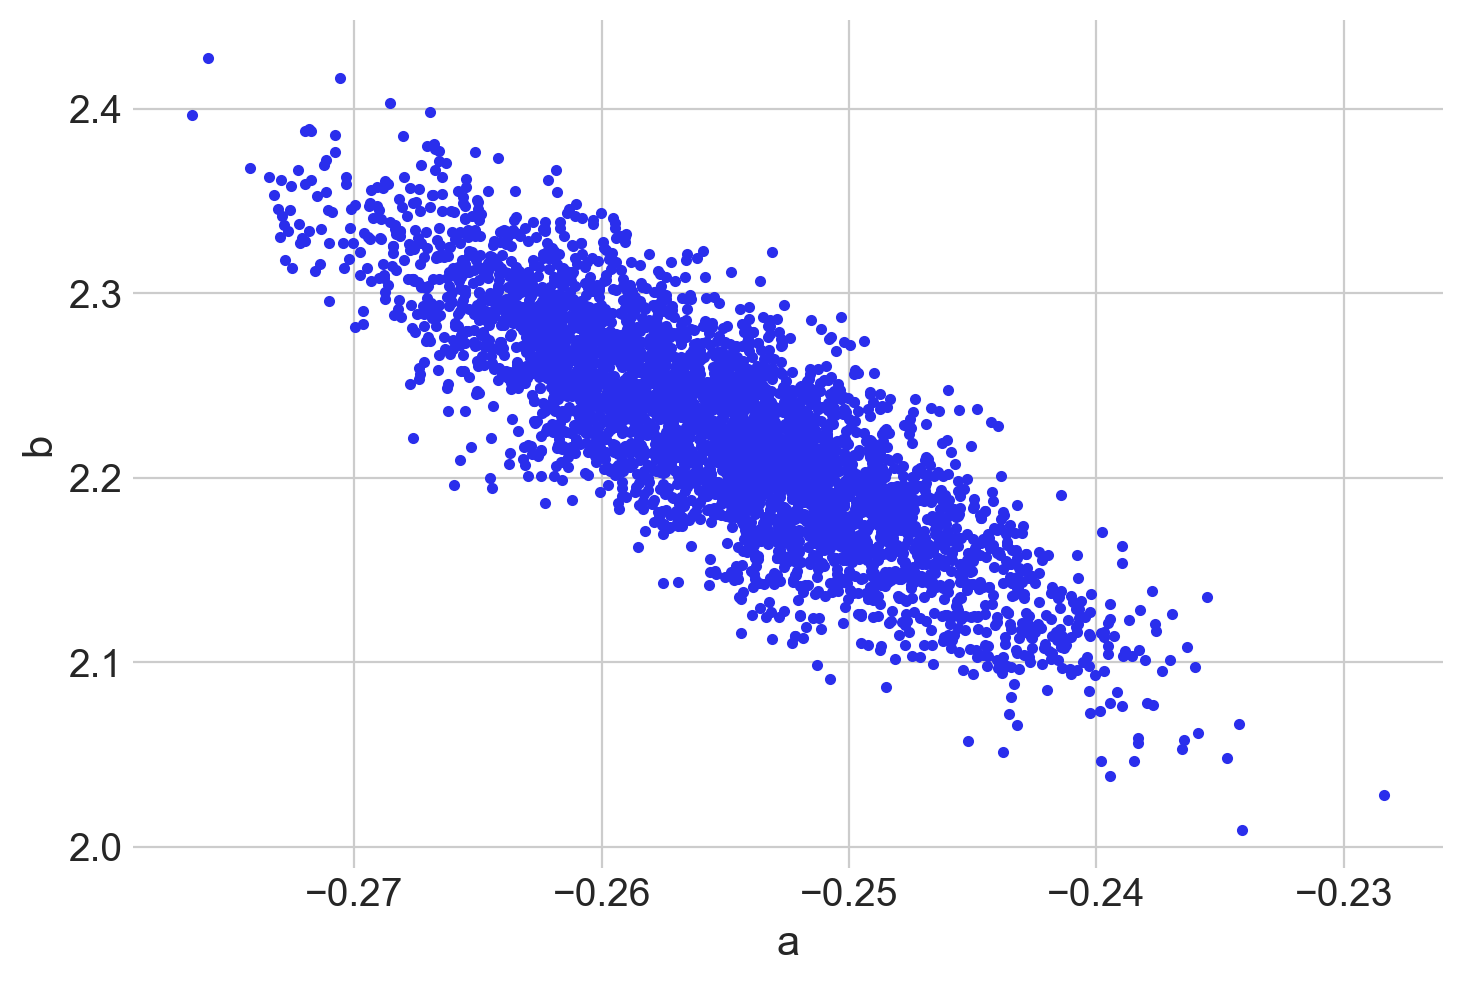

In [15]:
az.plot_pair(m1_logit_trace, var_names=["a", "b"]);

---

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Aug 05 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

pandas    : 1.3.1
janitor   : 0.21.0
pymc3     : 3.11.2
matplotlib: 3.4.2
scipy     : 1.7.0
arviz     : 0.11.2
numpy     : 1.21.1
seaborn   : 0.11.1
plotnine  : 0.8.0

Watermark: 2.2.0

